In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import seaborn as sns
from scipy.stats import mode
from numpy import mean, median

In [4]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#from sklearn.pipeline import make_pipeline

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.model_selection import cross_val_score

**1. Data Analysis.** 
Let us explore the data we are working with

In [7]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data.shape

(891, 12)

In [9]:
result_data = pd.read_csv('/kaggle/input/titanic/test.csv')
result_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
# here are some missing values in Age, Cabin and Embarked columns

for col in train_data.columns:
    print(col, train_data[col].isnull().any(), sum(train_data[col].isnull()))

PassengerId False 0
Survived False 0
Pclass False 0
Name False 0
Sex False 0
Age True 177
SibSp False 0
Parch False 0
Ticket False 0
Fare False 0
Cabin True 687
Embarked True 2


It's better to concatenate train and test so that to work on filling in the data

In [11]:
overall_data = pd.concat([train_data, result_data])
overall_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


First, the numerical data

In [12]:
overall_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [13]:
overall_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


Sex values may be easily transferred into binary values

In [14]:
# preprocess Sex data so that it is numerical 
overall_data.Sex.replace({'female': 0, 'male': 1}, inplace=True)

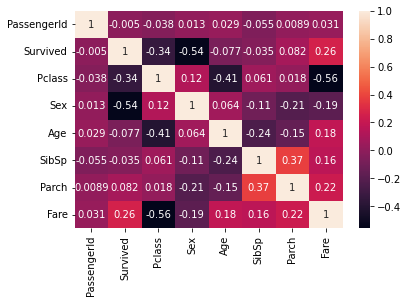

In [15]:
heatmap_corr = sns.heatmap(overall_data.corr(), annot=True)
# Let's assume strong correlation between survivalability and the following numerical data: 
# Pclass, Sex and Fare

In [16]:
train_data = overall_data[overall_data.Survived.notnull()]

In [17]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,S
887,888,1.0,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1.0,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C


In [18]:
categorical_data = ['Cabin', 'Embarked']

In [19]:
# as it was observed at the heatmap, again we can see Fare, Pclass and Sex values to differ quite a lot between the survived and decayed groups
pd.pivot_table(train_data, index='Survived', values=['Age', 'Sex', 'SibSp','Parch','Fare', 'Pclass'])

,Age,Fare,Parch,Pclass,Sex,SibSp
Survived,,,,,,
0.0,30.626179,22.117887,0.329690,2.531876,0.852459,0.553734
1.0,28.343690,48.395408,0.464912,1.950292,0.318713,0.473684


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


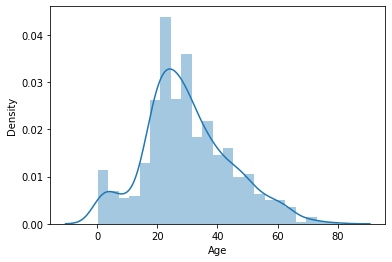

In [20]:
# The distribution seem to be normal, however, I would prefer to use either mode or median 
# to fill in Age
sns_plot = sns.distplot(overall_data.Age)
fig = sns_plot.get_figure()

In [21]:
print('Mode', overall_data.Age.mode())
print('Mean', overall_data.Age.mean())
print('Median', overall_data.Age.median())

Mode 0    24.0
dtype: float64
Mean 29.881137667304014
Median 28.0


In [22]:
# replace NaN with median value
overall_data.Age = overall_data.Age.fillna(overall_data.Age.median())

Second, categorical data

Among categorical data we have Name, Ticket, Cabin and Embarked
To simplify I am not going to work with Name; Ticket column value is supposed to be highly connected with Fare and Pclass and will not provide any valuable info here. Cabin info is to be turned into numerical via one-hot encoding

<AxesSubplot:ylabel='Embarked'>

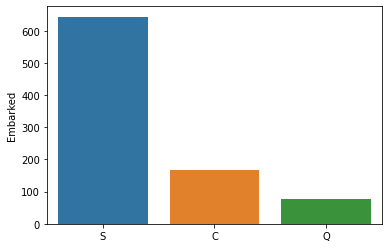

In [23]:
# I would check the Embarked column to see if it is somehow valueble in survivalability prediction
sns.barplot(x=train_data.Embarked.value_counts().index, y=train_data.Embarked.value_counts())

In [24]:
# seems like it might be worth trying to consider Embarked column
# so, it should be encoded as well as Cabin info
pd.pivot_table(train_data, index='Survived', columns='Embarked', values='PassengerId', aggfunc='count')

Embarked,C,Q,S
Survived,,,
0.0,75,47,427
1.0,93,30,217


Moreover, let's preprocess Cabin data so that they include letters only. Null values i would prefer to replace with a separate value like Q, as it might give the model more info than fillin in with a value

In [25]:
overall_data.Cabin = overall_data.Cabin.map(lambda cab: cab[0], na_action='ignore')
overall_data.Cabin.fillna('Q', inplace=True)

In [26]:
overall_data.Cabin.value_counts()

Q    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [27]:
train_data = overall_data[overall_data.Survived.notnull()]

In [28]:
dummies_cabin = pd.get_dummies(overall_data.Cabin, prefix='cab')

In [29]:
dummies_cabin

,cab_A,cab_B,cab_C,cab_D,cab_E,cab_F,cab_G,cab_Q,cab_T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
413,0,0,0,0,0,0,0,1,0
414,0,0,1,0,0,0,0,0,0
415,0,0,0,0,0,0,0,1,0
416,0,0,0,0,0,0,0,1,0


In [30]:
dummies_embarked = pd.get_dummies(overall_data.Embarked, prefix='emb')

In [31]:
overall_data[overall_data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B,NaN


Well, for survivalability prediction let's rely on Sex, Age, Fare, Cabin info, Pclass and Embarked columns

In [32]:
final_data = overall_data[['PassengerId', 'Survived', 'Sex', 'Age', 'Fare', 'Pclass']]

In [33]:
pd.concat([final_data, dummies_embarked], sort=False, axis=1)

,PassengerId,Survived,Sex,Age,Fare,Pclass,emb_C,emb_Q,emb_S
0,1,0.0,1,22.0,7.2500,3,0,0,1
1,2,1.0,0,38.0,71.2833,1,1,0,0
2,3,1.0,0,26.0,7.9250,3,0,0,1
3,4,1.0,0,35.0,53.1000,1,0,0,1
4,5,0.0,1,35.0,8.0500,3,0,0,1
...,...,...,...,...,...,...,...,...,...
413,1305,NaN,1,28.0,8.0500,3,0,0,1
414,1306,NaN,0,39.0,108.9000,1,1,0,0
415,1307,NaN,1,38.5,7.2500,3,0,0,1
416,1308,NaN,1,28.0,8.0500,3,0,0,1


In [34]:
final_overall_data = pd.concat([final_data, dummies_embarked, dummies_cabin], \
                               sort=False, axis=1)

In [35]:
final_overall_data

,PassengerId,Survived,Sex,Age,Fare,Pclass,emb_C,emb_Q,emb_S,cab_A,cab_B,cab_C,cab_D,cab_E,cab_F,cab_G,cab_Q,cab_T
0,1,0.0,1,22.0,7.2500,3,0,0,1,0,0,0,0,0,0,0,1,0
1,2,1.0,0,38.0,71.2833,1,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1.0,0,26.0,7.9250,3,0,0,1,0,0,0,0,0,0,0,1,0
3,4,1.0,0,35.0,53.1000,1,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0.0,1,35.0,8.0500,3,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,1,28.0,8.0500,3,0,0,1,0,0,0,0,0,0,0,1,0
414,1306,NaN,0,39.0,108.9000,1,1,0,0,0,0,1,0,0,0,0,0,0
415,1307,NaN,1,38.5,7.2500,3,0,0,1,0,0,0,0,0,0,0,1,0
416,1308,NaN,1,28.0,8.0500,3,0,0,1,0,0,0,0,0,0,0,1,0


Not to forget about scaling

In [36]:
scale = StandardScaler()

In [37]:
train_data = final_overall_data[final_overall_data.Survived.notnull()]
train_data.head(5)

,PassengerId,Survived,Sex,Age,Fare,Pclass,emb_C,emb_Q,emb_S,cab_A,cab_B,cab_C,cab_D,cab_E,cab_F,cab_G,cab_Q,cab_T
0,1,0.0,1,22.0,7.2500,3,0,0,1,0,0,0,0,0,0,0,1,0
1,2,1.0,0,38.0,71.2833,1,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1.0,0,26.0,7.9250,3,0,0,1,0,0,0,0,0,0,0,1,0
3,4,1.0,0,35.0,53.1000,1,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0.0,1,35.0,8.0500,3,0,0,1,0,0,0,0,0,0,0,1,0


In [38]:
result_data = final_overall_data[final_overall_data.Survived.isnull()]
result_data.head(5)

,PassengerId,Survived,Sex,Age,Fare,Pclass,emb_C,emb_Q,emb_S,cab_A,cab_B,cab_C,cab_D,cab_E,cab_F,cab_G,cab_Q,cab_T
0,892,NaN,1,34.5,7.8292,3,0,1,0,0,0,0,0,0,0,0,1,0
1,893,NaN,0,47.0,7.0000,3,0,0,1,0,0,0,0,0,0,0,1,0
2,894,NaN,1,62.0,9.6875,2,0,1,0,0,0,0,0,0,0,0,1,0
3,895,NaN,1,27.0,8.6625,3,0,0,1,0,0,0,0,0,0,0,1,0
4,896,NaN,0,22.0,12.2875,3,0,0,1,0,0,0,0,0,0,0,1,0


In [39]:
train_data_sc = train_data.drop('PassengerId', axis=1).drop('Survived', axis=1)
result_data_sc = result_data.drop('PassengerId', axis=1).drop('Survived', axis=1)

In [40]:
# there is one missing value in Fare that we need to fill in
result_data_sc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sex     418 non-null    int64  
 1   Age     418 non-null    float64
 2   Fare    417 non-null    float64
 3   Pclass  418 non-null    int64  
 4   emb_C   418 non-null    uint8  
 5   emb_Q   418 non-null    uint8  
 6   emb_S   418 non-null    uint8  
 7   cab_A   418 non-null    uint8  
 8   cab_B   418 non-null    uint8  
 9   cab_C   418 non-null    uint8  
 10  cab_D   418 non-null    uint8  
 11  cab_E   418 non-null    uint8  
 12  cab_F   418 non-null    uint8  
 13  cab_G   418 non-null    uint8  
 14  cab_Q   418 non-null    uint8  
 15  cab_T   418 non-null    uint8  
dtypes: float64(2), int64(2), uint8(12)
memory usage: 21.2 KB


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


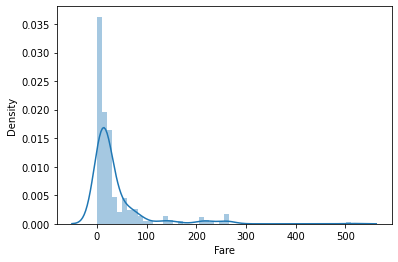

In [41]:
sns_plot = sns.distplot(result_data_sc.Fare)
fig = sns_plot.get_figure()

In [42]:
result_data_sc.Fare = result_data_sc.Fare.fillna(result_data_sc.Fare.median())

In [43]:
train_data_sc = scale.fit_transform(train_data_sc)
result_data_sc = scale.transform(result_data_sc)

Now we can finally go to the survivability

In [44]:
y = train_data['Survived']

In [45]:
X = train_data_sc

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

I am going to follow the scikit-learn cheat sheet and try LinearSVC, KNeighbors Classifier, SVC, Ensemble Classifiers as well as LogisticRegression

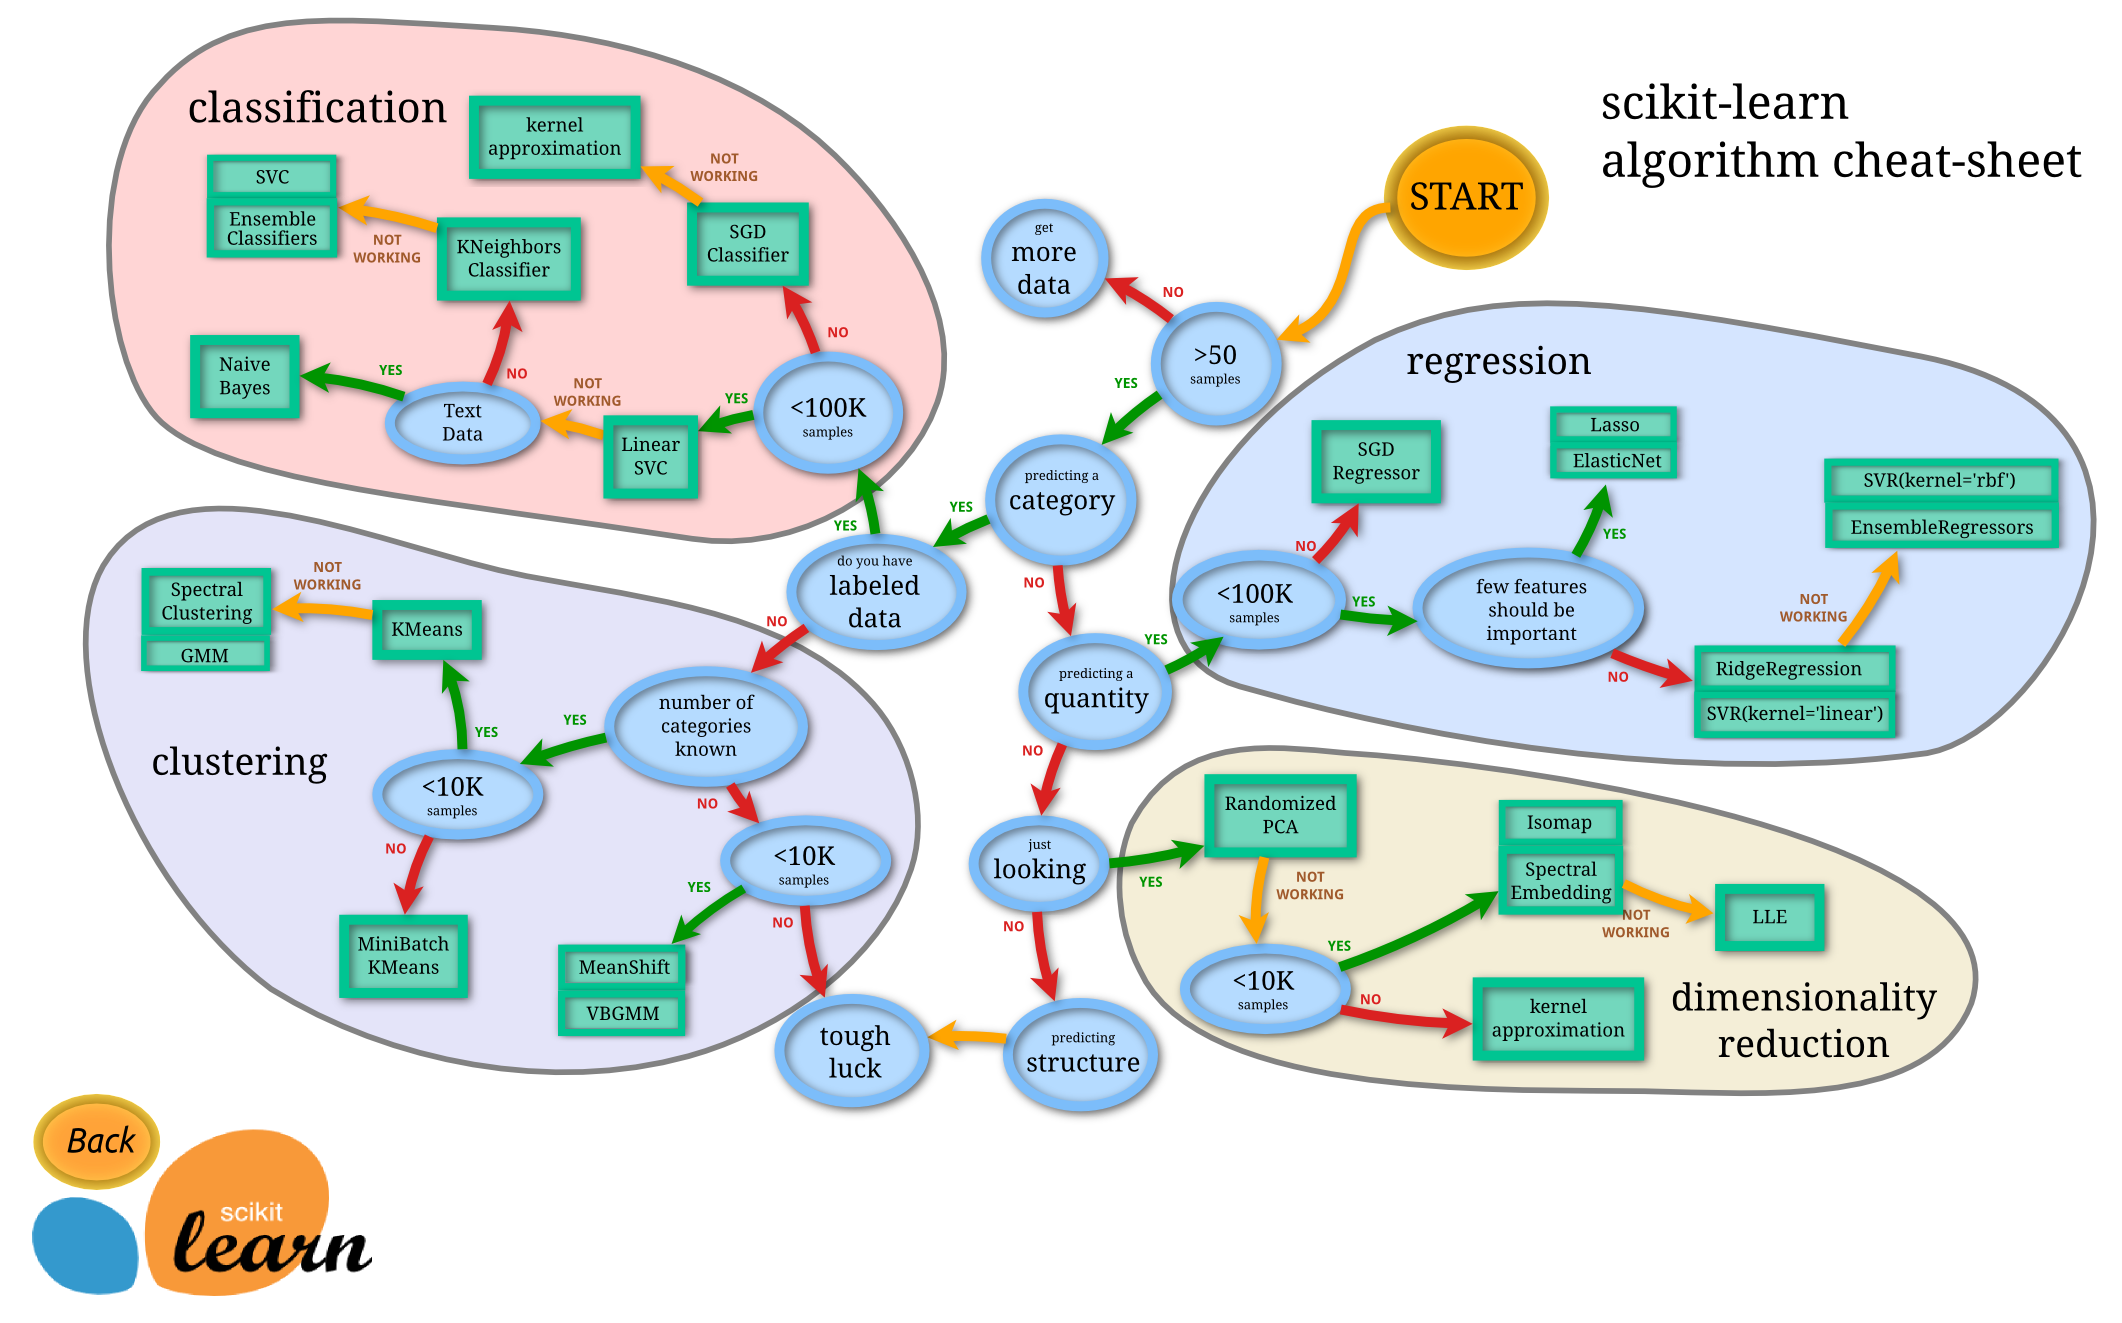

Let's check how the models perform with default settings

In [47]:
lsvc = LinearSVC(max_iter=5000, random_state=1)
cv = cross_val_score(lsvc, X_train, y_train, cv=5)
print(f'For LinearSVC the mean schore of cross validation is {round(cv.mean(), 2)}')

For LinearSVC the mean schore of cross validation is 0.79


In [48]:
knc = KNeighborsClassifier()
cv = cross_val_score(knc, X_train, y_train, cv=5)
print(f'For KNeighborsClassifier the mean schore of cross validation is {round(cv.mean(), 2)}')

For KNeighborsClassifier the mean schore of cross validation is 0.8


In [49]:
svc = SVC()
cv = cross_val_score(svc, X_train, y_train, cv=5)
print(f'For SVC the mean schore of cross validation is {round(cv.mean(), 2)}')

For SVC the mean schore of cross validation is 0.82


In [50]:
lr = LogisticRegression()
cv = cross_val_score(lr, X_train, y_train, cv=5)
print(f'For LogisticRegression the mean schore of cross validation is {round(cv.mean(), 2)}')

For LogisticRegression the mean schore of cross validation is 0.81


Anyways, let's take a look at the predictions

In [51]:
models = [lsvc, knc, svc, lr]
for mod in models:
    print(f'The model is {mod}')
    mod.fit(X_train, y_train)
    prediction = mod.predict(X_test)
    print(f'Accuracy for the model is '
          f'{round(accuracy_score(y_test, prediction), 2)}')
    print(classification_report(y_test, prediction))
    print()

The model is LinearSVC(max_iter=5000, random_state=1)
Accuracy for the model is 0.77
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       106
         1.0       0.72      0.73      0.72        73

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179


The model is KNeighborsClassifier()
Accuracy for the model is 0.74
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       106
         1.0       0.72      0.60      0.66        73

    accuracy                           0.74       179
   macro avg       0.74      0.72      0.73       179
weighted avg       0.74      0.74      0.74       179


The model is SVC()
Accuracy for the model is 0.75
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       106
         1.0       0.74      0.59

Let's go ensemble methods to see if we'll find any better results there

In [52]:
rfc = RandomForestClassifier()
cv = cross_val_score(rfc, X_train, y_train, cv=5)
print(f'For RandomForestClassifier the mean schore of cross validation is {round(cv.mean(), 2)}')

For RandomForestClassifier the mean schore of cross validation is 0.82


In [53]:
abc = AdaBoostClassifier()
cv = cross_val_score(abc, X_train, y_train, cv=5)
print(f'For AdaBoostClassifier the mean schore of cross validation is {round(cv.mean(), 2)}')

For AdaBoostClassifier the mean schore of cross validation is 0.8


In [54]:
gbc = GradientBoostingClassifier()
cv = cross_val_score(gbc, X_train, y_train, cv=5)
print(f'For GradientBoostingClassifier the mean schore of cross validation is {round(cv.mean(), 2)}')

For GradientBoostingClassifier the mean schore of cross validation is 0.83


In [55]:
ensembles = [rfc, abc, gbc]
for ens in ensembles:
    print(f'The model is {ens}')
    ens.fit(X_train, y_train)
    prediction = ens.predict(X_test)
    print(f'Accuracy for the model is '
          f'{round(accuracy_score(y_test, prediction), 2)}')
    print(classification_report(y_test, prediction))
    print()

The model is RandomForestClassifier()
Accuracy for the model is 0.78
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82       106
         1.0       0.77      0.64      0.70        73

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.77       179


The model is AdaBoostClassifier()
Accuracy for the model is 0.75
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.80       106
         1.0       0.71      0.67      0.69        73

    accuracy                           0.75       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179


The model is GradientBoostingClassifier()
Accuracy for the model is 0.78
              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83       106
         1.0       0.84     

So far we've got the following results with train/test prediction on default parameters:
1. GradientBoostingClassifier - **0.83/0.78**
2. RandomForestClassifier - **0.82/0.78**
3. SVC - 0.82/0.75
4. LogisticRegression - 0.81/0.75
5. AdaBoostClassifier - 0.8/0.75
6. KNeighborsClassifier - 0.8/0.74
7. LinearSVC - **0.79/0.77**

Let's go and try to adjust GradientBoostingClassifier, RandomForestClassifier and LinearSVC

In [127]:
gbc_tuning = {'n_estimators': list(range(100, 1500, 200)),
              'subsample': [num/10 for num in range(1, 11, 2)],
              'max_depth': list(range(1, 10)) + [None],
              'n_iter_no_change': list(range(5, 106, 20))}
gbc_t = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_tuning, 
                   cv=5, verbose=True, n_jobs=-1)
gbc_t = gbc_t.fit(X_train, y_train)
print(f'Train score after tuning is {gbc_t.best_score_}'
      f'The best parameters are {gbc_t.best_params_}')

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits
Train score after tuning is 0.8483699399192357The best parameters are {'max_depth': 4, 'n_estimators': 900, 'n_iter_no_change': 5, 'subsample': 0.9}


In [56]:
gbc_best = GradientBoostingClassifier(max_depth=4, n_estimators=900, 
                                      n_iter_no_change=5, subsample=0.9)
cv = cross_val_score(gbc_best, X_train, y_train, cv=5)
cv_test = cross_val_score(gbc_best, X_test, y_test, cv=5)
print(f'For GradientBoostingClassifier the mean schore of cross validation is {round(cv.mean(), 3)}')
print(f'Test result is {round(cv_test.mean(), 3)}')

For GradientBoostingClassifier the mean schore of cross validation is 0.83
Test result is 0.743


The result is not any better than of the default model

Then, RandomForestClassifier

In [136]:
rfc_tuning = {'n_estimators': list(range(100, 1001, 100)),
             'bootstrap': [True, False],
             'max_features': ['sqrt', 'log2', None],
             'max_depth': [None] + list(range(5, 101, 20))}
rfc_t = GridSearchCV(RandomForestClassifier(), param_grid=rfc_tuning, 
                   cv=5, verbose=True, n_jobs=-1)
rfc_t = rfc_t.fit(X_train, y_train)
print(f'Train score after tuning is {rfc_t.best_score_}'
      f'The best parameters are {rfc_t.best_params_}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Train score after tuning is 0.8483994878361075The best parameters are {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}


In [57]:
rfc_best = RandomForestClassifier(bootstrap=False, max_depth=5, 
                                  max_features='sqrt', n_estimators=300,
                                  random_state=1)
cv = cross_val_score(rfc_best, X_train, y_train, cv=5)
cv_test = cross_val_score(rfc_best, X_test, y_test, cv=5)
print(f'For RandomForestClassifier the mean schore of cross validation is {round(cv.mean(), 3)}')
print(f'Test result is {round(cv_test.mean(), 3)}')

For RandomForestClassifier the mean schore of cross validation is 0.847
Test result is 0.771


No big improvement either

In [69]:
lsvc_tuning = {'loss': ['hinge', 'squared_hinge'],
               'max_iter': list(range(5000, 9001, 250))}
lsvc_t = GridSearchCV(LinearSVC(), param_grid=lsvc_tuning, 
                   cv=5, verbose=True, n_jobs=-1)
lsvc_t = lsvc_t.fit(X_train, y_train)
print(f'Train score after tuning is {lsvc_t.best_score_}'
      f'The best parameters are {lsvc_t.best_params_}')

Fitting 5 folds for each of 34 candidates, totalling 170 fits
Train score after tuning is 0.7936078006500542The best parameters are {'loss': 'squared_hinge', 'max_iter': 5000}


In [58]:
lsvc_best = LinearSVC(loss='squared_hinge', max_iter=5000)
cv = cross_val_score(lsvc_best, X_train, y_train, cv=5)
cv_test = cross_val_score(lsvc_best, X_test, y_test, cv=5)
print(f'For RandomForestClassifier the mean schore of cross validation is {round(cv.mean(), 3)}')
print(f'Test result is {round(cv_test.mean(), 3)}')

For RandomForestClassifier the mean schore of cross validation is 0.794
Test result is 0.777


Random Forest Classifier as well as Linear SCV have demonstrated the best score of about 0.77 for test data so far. Thus, I am going to prepare final data based on both models

In [59]:
rfc_best.fit(X_train, y_train)
rfc_result_prediction = rfc_best.predict(result_data_sc)

In [67]:
rfc_result_prediction = pd.Series(rfc_result_prediction).map(int)

In [68]:
result_rfc = pd.DataFrame({'PassengerId': result_data.PassengerId,
                          'Survived': rfc_result_prediction})

In [69]:
result_rfc.to_csv('/kaggle/working/result_rfc.csv', index=False)

In [63]:
result_rfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.8 KB


In [70]:
lsvc_best.fit(X_train, y_train)
lsvc_result_prediction = lsvc_best.predict(result_data_sc)
lsvc_result_prediction = pd.Series(lsvc_result_prediction).map(int)
result_lsvc = pd.DataFrame({'PassengerId': result_data.PassengerId,
                          'Survived': lsvc_result_prediction})
result_lsvc.to_csv('/kaggle/working/result_lsvc.csv', index=False)

In [71]:
gbc_best.fit(X_train, y_train)
gbc_result_prediction = gbc_best.predict(result_data_sc)
gbc_result_prediction = pd.Series(gbc_result_prediction).map(int)
result_gbc = pd.DataFrame({'PassengerId': result_data.PassengerId,
                          'Survived': gbc_result_prediction})
result_gbc.to_csv('/kaggle/working/result_gbc.csv', index=False)

Finaly, after submitting predictions made by Random Forest Classifier, Linear SVC and Gradient Boosting Classifier I got the following results:

- GradientBoostingClassifier **0.77511**
- Random Forest Classifier **0.76555**
- Linear SVC **0.75358**